### Time to get your hands dirty! Cloning quasars
The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data. Does that agree with your expectation? 

(Hint: It shouldn't. But why?) 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from scipy.interpolate import CubicSpline
from astropy.visualization import hist
from astroML.density_estimation import EmpiricalDistribution
from astroML.datasets import fetch_dr7_quasar
import astropy

In [2]:
#Downloading the SDSS quasar data
astropy.cosmology.Planck15

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']
z.sort()

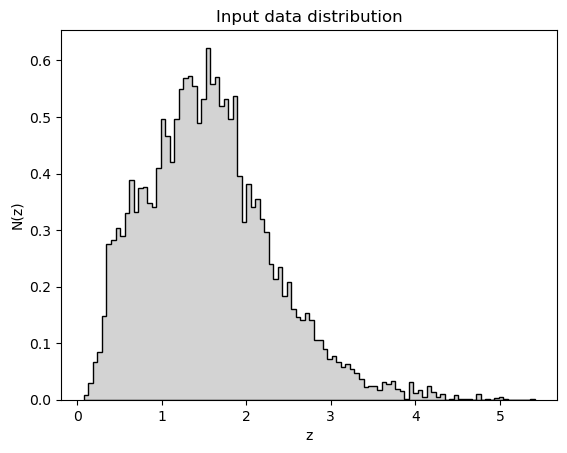

In [3]:
#Histogram of the data
plt.hist(z, 100, density = True, ec='black', fc='lightgrey', histtype='stepfilled')
plt.title('Input data distribution')
plt.xlabel('z')
plt.ylabel('N(z)')
plt.show()

## Rejection sampling

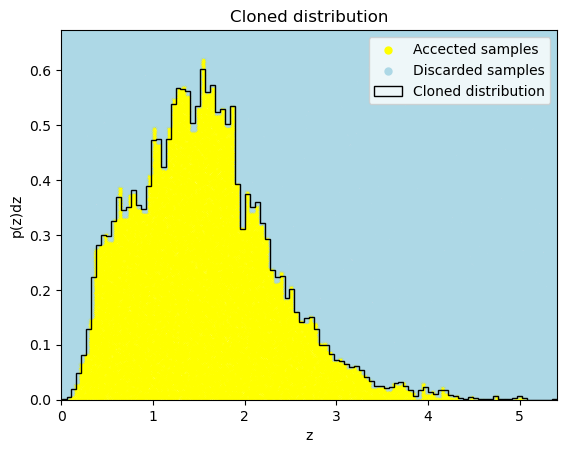

In [4]:
Nclone = 10**6  #Number of points sampled from the proposal distribution

counts, bins = np.histogram(z, 100, density = True)

x = np.random.uniform(0, max(z), Nclone)  #Data sampled from the proposal distribution, in this case it's a uniform distribution
y = np.random.uniform(0, max(counts) + 0.05, Nclone)  #Y values to confront with the values of the distribution 

ind = np.digitize(x, bins, right=True)  #This function return the index of the bin in which x is contained
                                        #(right=True means that each interval is close on the right)

cont = np.zeros(len(ind))
for i in range(len(ind)):   #Cont = Counts in each bin
    cont[i] = counts[ind[i]-1]

plt.scatter(x[y<cont], y[y<cont], c='yellow', s = 0.01, label = 'Accected samples')  #Plotting the accepted samples
plt.scatter(x[y>cont], y[y>cont], c='lightblue', s = 0.01, label = 'Discarded samples')  #Plotting the rejected samples

goodpoints = x[y<cont]
plt.hist(goodpoints, bins=100, density=True, histtype='step', color='black', label = 'Cloned distribution')  #Histogram of the cloned distribution

plt.xlim(0, max(z))
plt.ylim(0, max(counts) + 0.05)
plt.title('Cloned distribution')
plt.xlabel('z')
plt.ylabel('p(z)dz')
plt.legend(markerscale = 50, loc='upper right')
plt.show()

## Inverse transform sampling

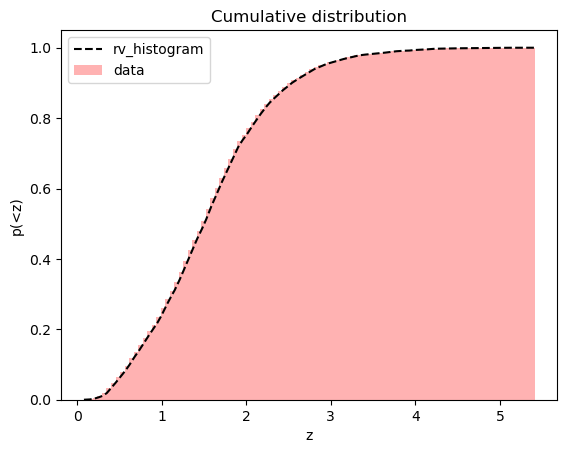

In [5]:
#Computing the cdf using rv_histogram
dist_z = stats.rv_histogram((counts,bins))  #This function creates a histogram-based probability distribution from the data
z_linspace = np.linspace(min(z), max(z), 10000)
plt.plot(z_linspace, dist_z.cdf(z_linspace), color = 'black', label = 'rv_histogram', ls='--')

#cdf from the data
plt.hist(z, 100, density = True, cumulative = True, color = 'red', label = 'data', alpha = 0.3)
plt.title('Cumulative distribution')
plt.ylabel('p(<z)')
plt.xlabel('z')
plt.legend()
plt.show()

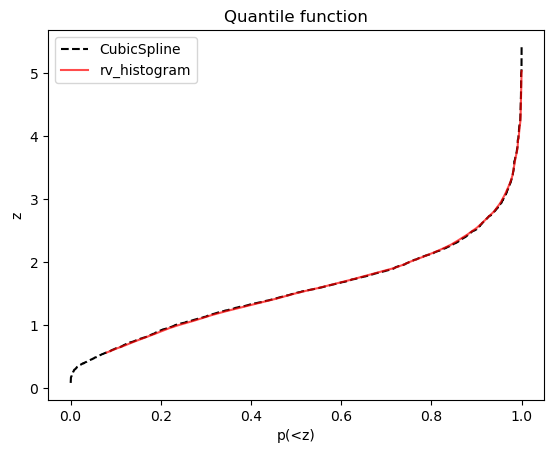

In [6]:
#Interpolation of the inverse cumulative distribution with CubicSpline
u = np.random.uniform(0, 1, 10000)
u.sort()
cs = CubicSpline(u, z) 
plt.plot(u, cs(u), label = "CubicSpline", color='black', ls='--')

#Finding the quantile function with rv_histogram
plt.plot(z_linspace, dist_z.ppf(z_linspace), color = 'red', label = 'rv_histogram', alpha = 0.7)

plt.title('Quantile function')
plt.xlabel('p(<z)')
plt.ylabel('z')
plt.legend()
plt.show()

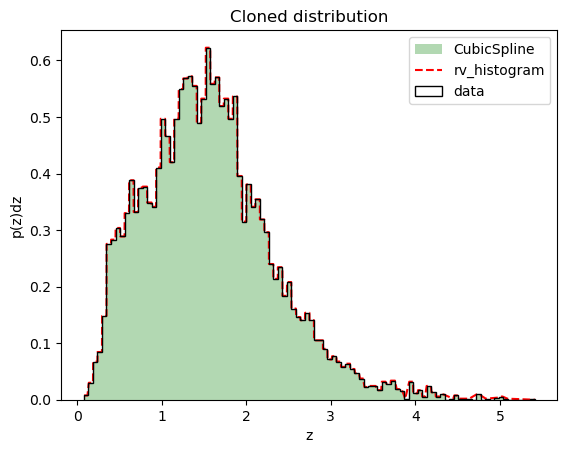

In [7]:
#Cloning the distribution using CubicSpline
plt.hist(cs(u), density=True, bins=100, label = 'CubicSpline', color = 'green', alpha = 0.3)

#Cloning the distribution using rv_histogram
plt.plot(z, dist_z.pdf(z), label = 'rv_histogram', color = 'red', ls='--')

#pdf of the data
plt.hist(z, bins=100, density=True, histtype='step', color='black', label = 'data')

plt.title('Cloned distribution')
plt.xlabel('z')
plt.ylabel('p(z)dz')
plt.legend()
plt.show()

## Cosmology

In [8]:
astropy.cosmology.Planck18  #Flat Lambda CDM model

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

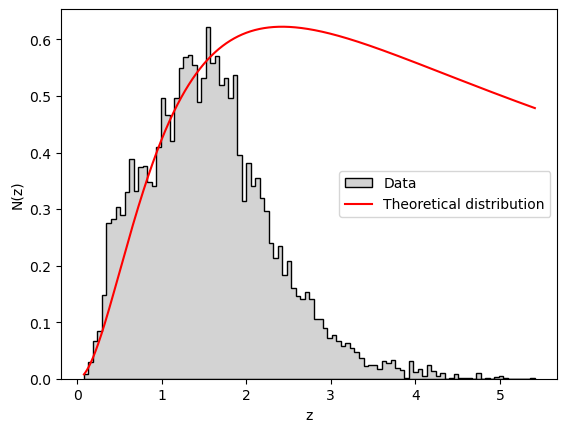

In [13]:
#Taking the comoving volume at each redshift
theory = astropy.cosmology.Planck18.differential_comoving_volume(z_linspace).value
theory = theory/(sum(theory))  #Computing the theoretical distribution

norm = (max(dist_z.pdf(z))/max(theory))  #Normalization
plt.hist(z, 100, density = True, ec='black', fc='lightgrey', histtype='stepfilled', label = 'Data')
plt.plot(z_linspace, norm*theory, color = 'red', label = 'Theoretical distribution')
plt.xlabel('z')
plt.ylabel('N(z)')
plt.legend()
plt.show()